In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix

In [121]:
# Extract data
X = np.load('Xtrain_Classification_Part1.npy')
y = np.load('Ytrain_Classification_Part1.npy')

X_train, X_validate, y_train, y_validate = train_test_split(X, y)

In [122]:

train_x_01 = X_train/255
validate_x_01 = X_validate/255

IM_WIDTH = IM_HEIGHT = 50

In [123]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Lambda, Dense, Flatten, Input

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x


    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def assemble_full_model(self, width, height):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 1)

        inputs = Input(shape=input_shape)

        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT)

In [124]:
model.summary()

Model: "face_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 50, 50, 16)        160       
_________________________________________________________________
activation_40 (Activation)   (None, 50, 50, 16)        0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 50, 50, 16)        64        
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 32)        464

In [125]:
from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
epochs = 100

opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={ 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'gender_output': 0.1},
              metrics={
                  'gender_output': 'accuracy'})

In [126]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32


pixels = 50
train_gen = []
valid_gen = []

for image in train_x_01:
    train_gen.append(image.reshape(pixels, pixels))
for image in validate_x_01:
    valid_gen.append(image.reshape(pixels, pixels))

train_gen = np.asarray(train_gen)

print(train_gen.shape)

y_train_r = np.asarray(y_train).astype('float32' ) #.reshape((-1,1))
y_validate_r = np.asarray(y_validate).astype('float32') #.reshape((-1,1))


#train_gen = train_x_01
#valid_gen = validate_x_01

history = model.fit(x=train_gen,
                    y=y_train_r,
                    steps_per_epoch=len(train_x_01)//batch_size,
                    epochs=epochs,
                    validation_data=(valid_gen, y_validate_r),
                    validation_steps=len(validate_x_01)//valid_batch_size)

(4852, 50, 50)
Epoch 1/100


ValueError: in user code:

    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))


BACC = 84.61360675063598


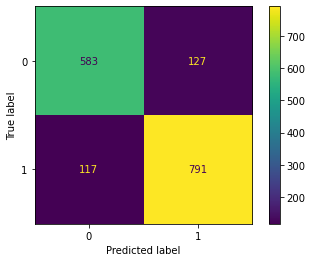

In [ ]:
y_hat = (model.predict(validate_x_01) > 0.5).astype("int32")
bacc = balanced_accuracy_score(y_validate, y_hat)

cm = confusion_matrix(y_validate, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
print(f"BACC = {bacc * 100}")